This notebook reproduces the Lorentz results from [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116). The data generation is specified in the  [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) of [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116), and is restated here. 


The data was syntheticaly generated using the governing lorentz
equations


$$
\begin{aligned}
\dot{z}_1 =& \sigma (z_2 - z_1) \\



\dot{z}_2 =& z_1 (\rho - z_3) - z_2 \\



\dot{z}_3 =& z_1 z_2 - \beta z_3 \\

\end{aligned}
$$

with the standard paramater values $\sigma = 10$, $\beta = \frac{8}{3}$ and $\rho = 28$

This data is then trnsformed using the first 6 legendre polynomials.


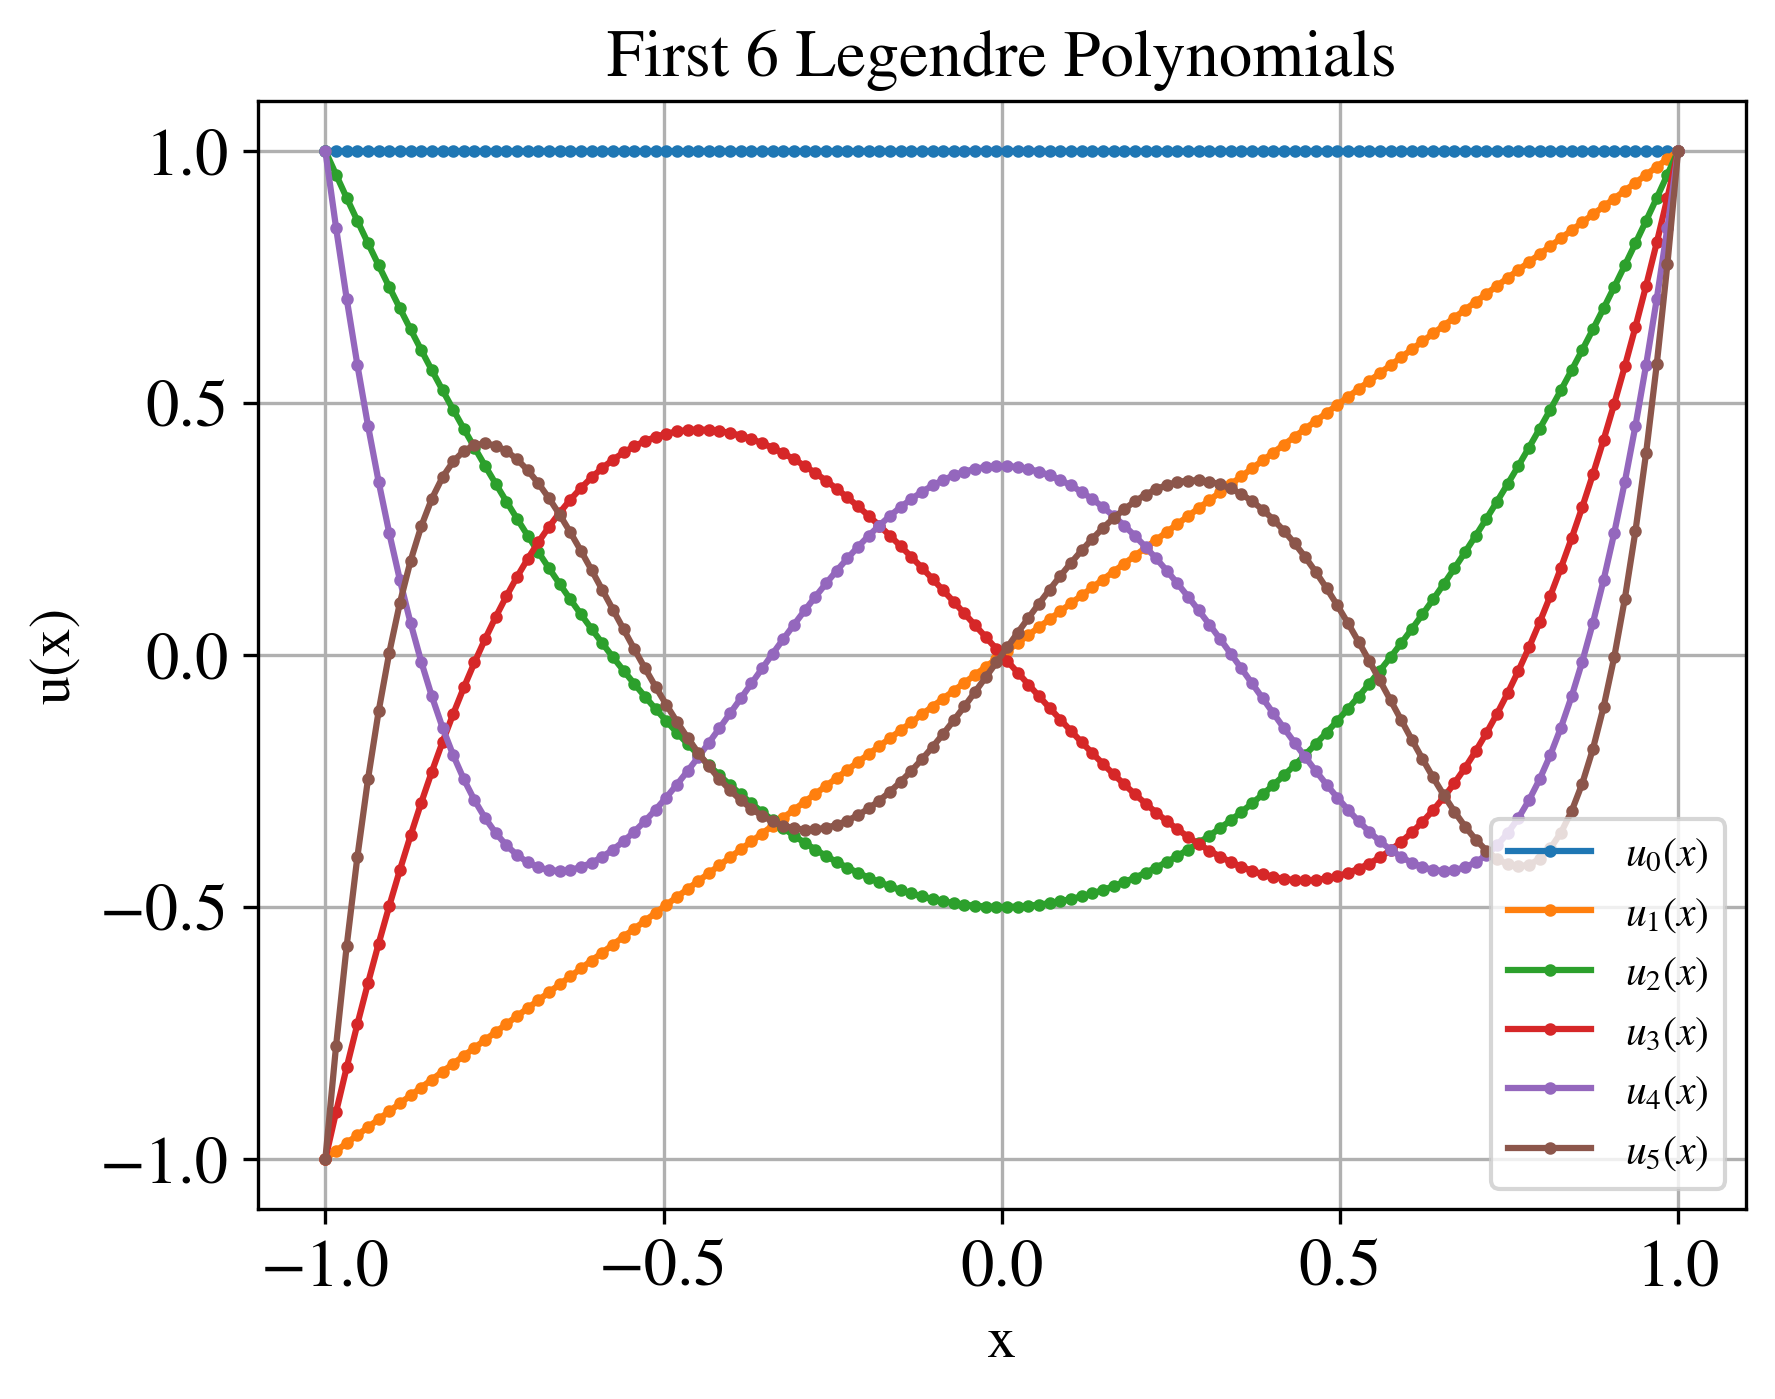

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import legendre

plt.style.use("../plot_utils/plot_settings.mplstyle")

x = np.linspace(-1, 1, 128)

# Plot the first 6 Legendre polynomials
for n in range(6):
    u_n = legendre(n)
    y = u_n(x)
    # Plot the polynomial
    #make the 
    plt.plot(x, y, label=f'$u_{n}(x)$', marker='o', markersize=2)


plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('First 6 Legendre Polynomials')
plt.legend()
plt.grid(True)



Each datapoint $\boldsymbol{z} = [z_1, z_2, z_3]$ is mapped to a $\boldsymbol{x}$ by

$$
\boldsymbol{x}(t) = \boldsymbol{u_1} z_1(t) +  \boldsymbol{u_2}z_2(t) +  \boldsymbol{u_3}z_3(t) +  \boldsymbol{u_4}z_1(t)^3 +  \boldsymbol{u_5}z_2(t)^3 +  \boldsymbol{u_6} z_3(t)^3 
$$

Our $\boldsymbol{u}_n \in \mathbb{R}^{128}$ vectors correspond precisely to the ones depicted above; these are constructed by sampling the $n$-th Legendre polynomial at 128 equally spaced points within the interval $[-1, 1]$.

From the [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) 
"To generate our data set, we simulate the system with 2048 initial conditions for the training set, 20 for the validation set, and 100 for the test set. For each initial condition we integrate the system forward in time from t = 0 to t = 5 with a spacing of ∆t = 0.02 to obtain 250 samples. Initial conditions 93 are chosen randomly from a uniform distribution over $z_1$ ∈ [−36, 36], $z_2$ ∈ [−48, 48], $z_3$ ∈ [−16, 66]. This results in a training 94 set with 512,000 total samples"

The functions for generating such data is taken from [Kathleens github](https://github.com/kpchamp/SindyAutoencoders) and simply wrapped in some simple functions to create pytorch dataloaders.

In [2]:
import jax
from jax.lib import xla_bridge

print(f"JAX is using: {xla_bridge.get_backend().platform}")
devices = jax.devices()
print(f"Number of devices: {len(devices)}")
for device in devices:
    print(device)


JAX is using: cpu
Number of devices: 1
TFRT_CPU_0


In [3]:
from lorenzData import get_lorenz_data, get_lorenz_OutOfDistro_data
from data_utils import create_jax_batches_factory

create_jax_batches = create_jax_batches_factory(second_order=False)


# Define all arguments as variables
n_ics_training = 2048
n_ics_validation = 20
n_ics_testing = 100

noise_strength = 1e-6
batch_size_training = 8000
batch_size_validation = 5000
batch_size_testing = 5000




training_data = get_lorenz_data(n_ics_training, noise_strength)
train_loader = create_jax_batches(training_data, batch_size_training)


validation_data = get_lorenz_data(n_ics_validation) #no noise for validation
validation_loader = create_jax_batches(validation_data, batch_size_validation)

#out of sample testing, kathleen does this so it's nice for camparison. Agreed
out_of_sample_testing_data = get_lorenz_OutOfDistro_data(n_ics_testing) #no noise for test data
out_of_sample_testing_loader = create_jax_batches(out_of_sample_testing_data, batch_size_testing)




In [4]:
input_dim = 128
latent_dim = 3
poly_order = 3
widths = [64, 32]

seed = 69 # OBS: This seed is used for the initial weights of the model

initial_epochs = 10001
final_epochs = 1001

# Get example input from training_data loader
x, dx = train_loader[0]

# Define hyperparameters dictionary
hparams = {
    'input_dim': input_dim,
    'latent_dim': latent_dim,
    'poly_order': poly_order,
    'widths': widths,
    'activation': 'sigmoid',
    'weight_initializer': 'xavier_uniform',
    'bias_initializer': 'zeros',
    'optimizer_hparams': {'optimizer': "adam"},
    'include_sine': False,  # Extracted from loss_params
    'loss_weights': (1, 1e-4, 0, 1e-5),  # Extracted from loss_params['weights']
    'seed': seed,
    'update_mask_every_n_epoch': 500,
    'coefficient_threshold': 0.1,
    'regularization': True,  
    'second_order': False,  
    'include_constant': True  
}

# Define other parameters dictionary
trainer_params = {
    'exmp_input': x,
    'logger_params': {},
    'enable_progress_bar': True,
    'debug': False,
    'check_val_every_n_epoch': 100
}


In [5]:
import sys

sys.path.append('../')

from trainer import SINDy_trainer
# combine the two dictionaries
params = {**hparams, **trainer_params}

# Initialize the trainer
trainer = SINDy_trainer(**params)



In [6]:

trainer.train_model(train_loader, validation_loader, out_of_sample_testing_loader, num_epochs=10001, final_epochs=1001)

Epochs:   0%|          | 0/10001 [00:02<?, ?it/s]


KeyboardInterrupt: 

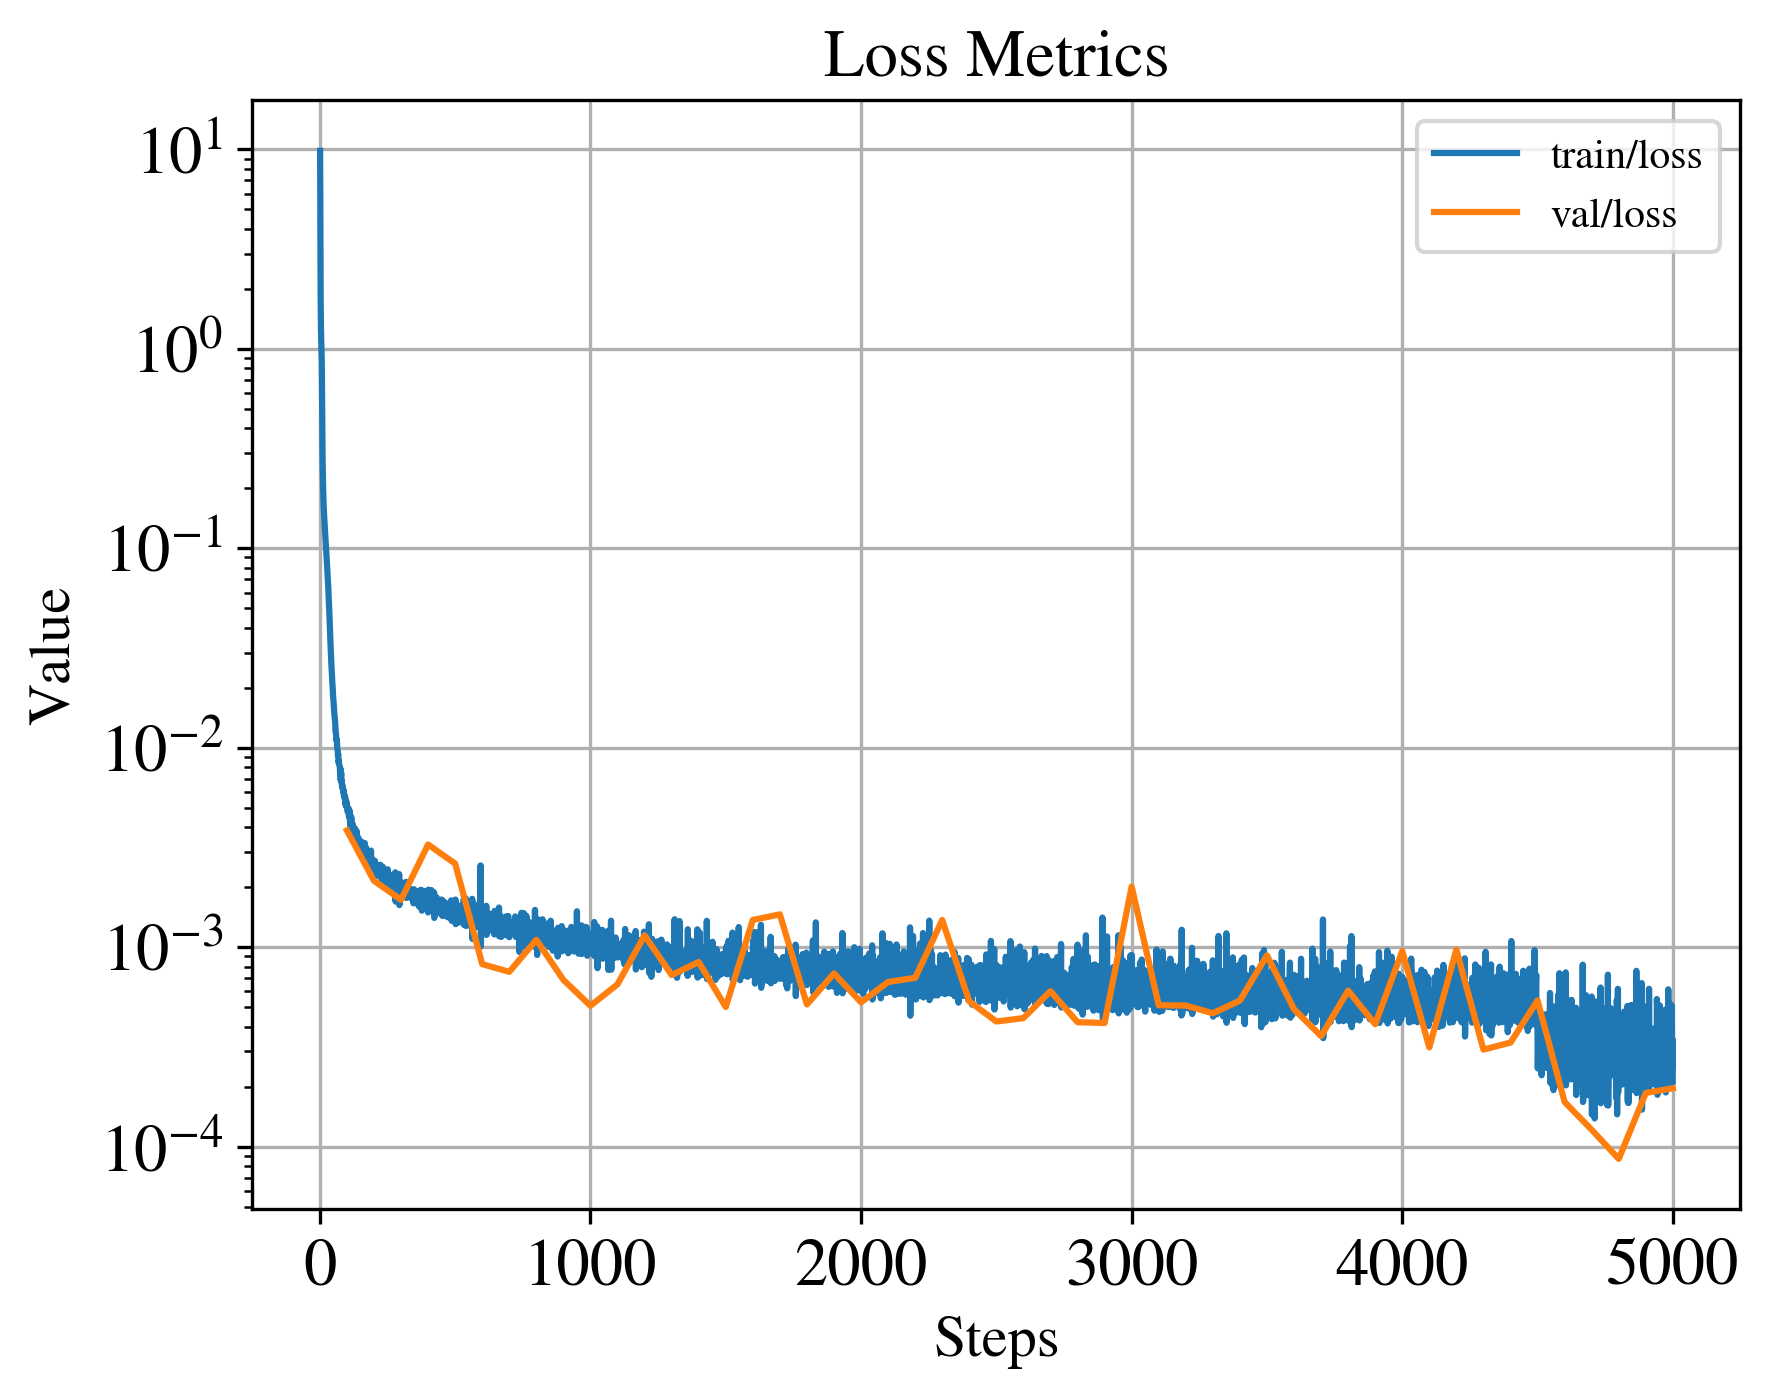

In [ ]:
from metrics import RunMetrics # type: ignore -goofy linitng issue
from plot_metrics import plot_metrics # type: ignore -goofy linitng issue

log_dir = trainer.log_dir

metrics = RunMetrics(log_dir)

# Plot a single run
plot_metrics(metrics, metric_names=["train/loss", "val/loss"], title="Loss Metrics")


## Get the sparse representation of the model ($\Xi$ )

In [ ]:
mask = trainer.state.mask
xi = trainer.state.params['sindy_coefficients']
xi = xi * mask

print(xi)

[[  6.3379335   -2.9177148   -0.        ]
 [ -1.0387433    0.          -9.6659975 ]
 [  0.           0.9047189   -0.        ]
 [  0.          -0.          -0.        ]
 [  0.31607652  -1.3514365   -7.4890003 ]
 [  9.466383    -0.           0.        ]
 [ -0.           0.           0.        ]
 [ -0.          -0.          -0.        ]
 [ -0.           0.           0.        ]
 [  0.          -0.          -0.        ]
 [ -2.6654594    0.          -3.5432577 ]
 [ -0.         -13.560588    -0.        ]
 [ -0.           0.          -0.        ]
 [  0.           0.          -0.        ]
 [ -0.           0.           0.        ]
 [  0.          -0.           0.        ]
 [ -0.           0.           0.        ]
 [  0.           0.          -0.        ]
 [  0.           0.           0.        ]
 [ -0.           0.           0.        ]]
